# YOLOv5

You Only Look Once(YOLO) is a family of object detection models known for its fast inferencing speed. From the first YOLO idea to the current YOLOv5, different authors have proposed various improvements on object detection accuracy and inferencing speed.

What makes YOLO standout is its core idea of combining region proposal and classification together so the network can be trained together. Specifically, YOLO splits the image into N x N grid, and each object is "assigned" to the corresponding grid. 

Comparing YOLOv5 against initial YOLO implementation, YOLOv5 utilizes many new ideas that others proposed throughout the year. Here is a summary of technical details of Yolov5:
* **Mosaic data augmentation**: combining 4 images together to increase the diversity and number of objects of each sample.
* **HSV augmentation**: changes the pixel saturation to further increase input image diversity
* **Assigning object using ratio between object size and anchor box size**: traditionally an object is assigned using IOU calculation, the drawback of using IOU assignment is that it often results in limited number of matches.
* **Double assignment of object**: To improve the number of matches further, once an object "matches" to an anchor box, then the next spatially closest anchor box is also matched.
* **SILU activation**: The SILU activation is x * sigmoid(x). It combines the advantage of ReLu and Sigmoid together. It is continuous, at the same time, robust against vanishing gradient.
* **Convolution Block**: The convolution block is Conv + Batchnorm + SILU (Activation) combination. The bias is only applied in the last prediction conv layer to prevent over-fitting.
* **BottleNeck**: Bottleneck consists of multiple convolution blocks, usually in forms of skip connection: output = conv2(conv1(x)) + x 
* **Focus Block**: In the beginning of the network, it halves the spatial size by sampling every other pixel and later cocatenate them in the channel dimension. As a result, the output dimension becomes [h/2, w/2, c * 4], it translates width-height information into the channel space.
* **Spatial Pyramid Pooling layer**: Spatial pyramid pooling applies different kernel size of pooling (with stride 1) so that the final outcome can represent information at different smoothing range. Formula: output =  conv -> concat[identity, pool(5), pool(9), pool(13)]) -> conv2
* **IOU loss for coordinates**: Using IOU loss rather than traditional coordinate regression loss can better represent how close between the prediction box and ground truth box.
* **Per-class NMS**: Different from many other detection models, YOLO performs NMS separately for each class to increase the precision.

Now let's implement this beautiful algorithm together in TensorFlow. First import necessary functions:

In [1]:
import math
import random
import tempfile

import cv2
import numpy as np
import tensorflow as tf
from albumentations import BboxParams
from tensorflow.keras import layers
from tensorflow.keras.initializers import Constant
from torch.utils.data import Dataset

import fastestimator as fe
from fastestimator.dataset.data import mscoco
from fastestimator.op.numpyop import Delete, NumpyOp
from fastestimator.op.numpyop.meta import Sometimes
from fastestimator.op.numpyop.multivariate import CenterCrop, HorizontalFlip, LongestMaxSize, PadIfNeeded
from fastestimator.op.numpyop.univariate import ReadImage, ToArray
from fastestimator.op.tensorop import Average, TensorOp
from fastestimator.op.tensorop.loss import LossOp
from fastestimator.op.tensorop.model import ModelOp, UpdateOp
from fastestimator.schedule import EpochScheduler, cosine_decay
from fastestimator.trace.adapt import LRScheduler
from fastestimator.trace.io import BestModelSaver
from fastestimator.trace.metric import MeanAveragePrecision
from fastestimator.util import get_num_devices

In [2]:
data_dir = None
model_dir = tempfile.mkdtemp()
epochs=200
batch_size_per_gpu=16
train_steps_per_epoch=None
eval_steps_per_epoch=None

## Dataset

During training, it uses mosaic dataset augmentation, then pad to the longest size, followed by horizontal flip and HSV augmentation. In the meantime, we will also create the ground truth vector to help calculate loss later.

In [3]:
# This dataset selects 4 images and their bboxes
class PreMosaicDataset(Dataset):
    def __init__(self, mscoco_ds):
        self.mscoco_ds = mscoco_ds

    def __len__(self):
        return len(self.mscoco_ds)

    def __getitem__(self, idx):
        indices = [idx] + [random.randint(0, len(self) - 1) for _ in range(3)]
        samples = [self.mscoco_ds[i] for i in indices]
        return {
            "image1": samples[0]["image"],
            "bbox1": samples[0]["bbox"],
            "image2": samples[1]["image"],
            "bbox2": samples[1]["bbox"],
            "image3": samples[2]["image"],
            "bbox3": samples[2]["bbox"],
            "image4": samples[3]["image"],
            "bbox4": samples[3]["bbox"]
        }


class CombineMosaic(NumpyOp):
    def forward(self, data, state):
        image1, image2, image3, image4, bbox1, bbox2, bbox3, bbox4 = data
        images = [image1, image2, image3, image4]
        bboxes = [bbox1, bbox2, bbox3, bbox4]
        images_new, boxes_new = self._combine_images_boxes(images, bboxes)
        return images_new, boxes_new

    def _combine_images_boxes(self, images, bboxes):
        s = 640
        yc, xc = int(random.uniform(320, 960)), int(random.uniform(320, 960))
        images_new = np.full((1280, 1280, 3), fill_value=114, dtype=np.uint8)
        bboxes_new = []
        for idx, (image, bbox) in enumerate(zip(images, bboxes)):
            h, w = image.shape[0], image.shape[1]
            # place img in img4
            if idx == 0:  # top left
                x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
            elif idx == 1:  # top right
                x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
                x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
            elif idx == 2:  # bottom left
                x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, w, min(y2a - y1a, h)
            elif idx == 3:  # bottom right
                x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)
            images_new[y1a:y2a, x1a:x2a] = image[y1b:y2b, x1b:x2b]
            padw, padh = x1a - x1b, y1a - y1b
            for x1, y1, bw, bh, label in bbox:
                x1_new = np.clip(x1 + padw, x1a, x2a)
                y1_new = np.clip(y1 + padh, y1a, y2a)
                x2_new = np.clip(x1 + padw + bw, x1a, x2a)
                y2_new = np.clip(y1 + padh + bh, y1a, y2a)
                bw_new = x2_new - x1_new
                bh_new = y2_new - y1_new
                if bw_new * bh_new > 1:
                    bboxes_new.append((x1_new, y1_new, bw_new, bh_new, label))
        return images_new, bboxes_new


class HSVAugment(NumpyOp):
    def __init__(self, inputs, outputs, mode="train", hsv_h=0.015, hsv_s=0.7, hsv_v=0.4):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)
        self.hsv_h = hsv_h
        self.hsv_s = hsv_s
        self.hsv_v = hsv_v

    def forward(self, data, state):
        img = data
        r = np.random.uniform(-1, 1, 3) * [self.hsv_h, self.hsv_s, self.hsv_v] + 1  # random gains
        hue, sat, val = cv2.split(cv2.cvtColor(img, cv2.COLOR_RGB2HSV))
        dtype = img.dtype  # uint8
        x = np.arange(0, 256, dtype=np.int16)
        lut_hue = ((x * r[0]) % 180).astype(dtype)
        lut_sat = np.clip(x * r[1], 0, 255).astype(dtype)
        lut_val = np.clip(x * r[2], 0, 255).astype(dtype)
        img_hsv = cv2.merge((cv2.LUT(hue, lut_hue), cv2.LUT(sat, lut_sat), cv2.LUT(val, lut_val))).astype(dtype)
        img = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB)
        return img


class CategoryID2ClassID(NumpyOp):
    def __init__(self, inputs, outputs, mode=None):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)
        missing_category = [66, 68, 69, 71, 12, 45, 83, 26, 29, 30]
        category = [x for x in range(1, 91) if not x in missing_category]
        self.mapping = {k: v for k, v in zip(category, list(range(80)))}

    def forward(self, data, state):
        if data.size > 0:
            classes = np.array([self.mapping[int(x)] for x in data[:, -1]], dtype="float32")
            data[:, -1] = classes
        else:
            data = np.zeros(shape=(1, 5), dtype="float32")
        return data


class GTBox(NumpyOp):
    def __init__(self, inputs, outputs, image_size, mode=None):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)
        self.image_size = image_size
        self.anchor_s = [(10, 13), (16, 30), (33, 23)]
        self.anchor_m = [(30, 61), (62, 45), (59, 119)]
        self.anchor_l = [(116, 90), (156, 198), (373, 326)]

    def forward(self, data, state):
        bbox = data[np.sum(data, 1) > 0]
        if bbox.size > 0:
            gt_sbbox = self._generate_target(data, anchors=self.anchor_s, feature_size=80)
            gt_mbbox = self._generate_target(data, anchors=self.anchor_m, feature_size=40)
            gt_lbbox = self._generate_target(data, anchors=self.anchor_l, feature_size=20)
        else:
            gt_sbbox = np.zeros((80, 80, 3, 6), dtype="float32")
            gt_mbbox = np.zeros((40, 40, 3, 6), dtype="float32")
            gt_lbbox = np.zeros((20, 20, 3, 6), dtype="float32")
        return gt_sbbox, gt_mbbox, gt_lbbox

    def _generate_target(self, bbox, anchors, feature_size, wh_threshold=4.0):
        object_boxes, label = bbox[:, :-1], bbox[:, -1]
        gt_bbox = np.zeros((feature_size, feature_size, 3, 6), dtype="float32")
        for object_idx, object_box in enumerate(object_boxes):
            for anchor_idx, anchor in enumerate(anchors):
                ratio = object_box[2:] / np.array(anchor, dtype="float32")
                match = np.max(np.maximum(ratio, 1 / ratio)) < wh_threshold
                if match:
                    center_feature_map = (object_box[:2] + object_box[2:] / 2) / self.image_size * feature_size
                    candidate_coords = self._get_candidate_coords(center_feature_map, feature_size)
                    for xc, yc in candidate_coords:
                        gt_bbox[yc, xc, anchor_idx][:4] = object_box  # use absoulte x1,y1,w,h
                        gt_bbox[yc, xc, anchor_idx][4] = 1.0
                        gt_bbox[yc, xc, anchor_idx][5] = label[object_idx]
        return gt_bbox

    @staticmethod
    def _get_candidate_coords(center_feature_map, feature_size):
        xc, yc = center_feature_map
        candidate_coords = [(int(xc), int(yc))]
        if xc % 1 < 0.5 and xc > 1:
            candidate_coords.append((int(xc) - 1, int(yc)))
        if xc % 1 >= 0.5 and xc < feature_size - 1:
            candidate_coords.append((int(xc) + 1, int(yc)))
        if yc % 1 < 0.5 and yc > 1:
            candidate_coords.append((int(xc), int(yc) - 1))
        if yc % 1 >= 0.5 and yc < feature_size - 1:
            candidate_coords.append((int(xc), int(yc) + 1))
        return candidate_coords

## Pipeline

Now that we have the necessary components, we are ready to create the data pipeline. In TensorFlow, the batch size is 16 for 640 x 640 image on 11Gb VRAM GPU. The batch size can be scaled up by adding more number of GPUs.

In [4]:
num_device = get_num_devices()
train_ds, val_ds = mscoco.load_data(root_dir=data_dir)
train_ds = PreMosaicDataset(mscoco_ds=train_ds)
batch_size = num_device * batch_size_per_gpu
pipeline = fe.Pipeline(
    train_data=train_ds,
    eval_data=val_ds,
    batch_size=batch_size,
    ops=[
        ReadImage(inputs=("image1", "image2", "image3", "image4"),
                  outputs=("image1", "image2", "image3", "image4"),
                  mode="train"),
        ReadImage(inputs="image", outputs="image", mode="eval"),
        LongestMaxSize(max_size=640,
                       image_in="image1",
                       bbox_in="bbox1",
                       bbox_params=BboxParams("coco", min_area=1.0),
                       mode="train"),
        LongestMaxSize(max_size=640,
                       image_in="image2",
                       bbox_in="bbox2",
                       bbox_params=BboxParams("coco", min_area=1.0),
                       mode="train"),
        LongestMaxSize(max_size=640,
                       image_in="image3",
                       bbox_in="bbox3",
                       bbox_params=BboxParams("coco", min_area=1.0),
                       mode="train"),
        LongestMaxSize(max_size=640,
                       image_in="image4",
                       bbox_in="bbox4",
                       bbox_params=BboxParams("coco", min_area=1.0),
                       mode="train"),
        LongestMaxSize(max_size=640,
                       image_in="image",
                       bbox_in="bbox",
                       bbox_params=BboxParams("coco", min_area=1.0),
                       mode="eval"),
        PadIfNeeded(min_height=640,
                    min_width=640,
                    image_in="image",
                    bbox_in="bbox",
                    bbox_params=BboxParams("coco", min_area=1.0),
                    mode="eval",
                    border_mode=cv2.BORDER_CONSTANT,
                    value=(114, 114, 114)),
        CombineMosaic(inputs=("image1", "image2", "image3", "image4", "bbox1", "bbox2", "bbox3", "bbox4"),
                      outputs=("image", "bbox"),
                      mode="train"),
        CenterCrop(height=640,
                   width=640,
                   image_in="image",
                   bbox_in="bbox",
                   bbox_params=BboxParams("coco", min_area=1.0),
                   mode="train"),
        Sometimes(
            HorizontalFlip(image_in="image",
                           bbox_in="bbox",
                           bbox_params=BboxParams("coco", min_area=1.0),
                           mode="train")),
        HSVAugment(inputs="image", outputs="image", mode="train"),
        ToArray(inputs="bbox", outputs="bbox", dtype="float32"),
        CategoryID2ClassID(inputs="bbox", outputs="bbox"),
        GTBox(inputs="bbox", outputs=("gt_sbbox", "gt_mbbox", "gt_lbbox"), image_size=640),
        Delete(keys=("image1", "image2", "image3", "image4", "bbox1", "bbox2", "bbox3", "bbox4"),
               mode="train"),
        Delete(keys="image_id", mode="eval")
    ],
    pad_value=0)

## Visualize Pipeline Preprocessing Results

In [5]:
import random
from matplotlib import pyplot as plt


BOX_COLOR = (255, 0, 0)  # Red
TEXT_COLOR = (255, 255, 255)  # White

def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min +
                                                 w), int(y_min), int(y_min + h)

    cv2.rectangle(img, (x_min, y_min), (x_max, y_max),
                  color=color,
                  thickness=thickness)

    ((text_width, text_height), _) = cv2.getTextSize(class_name,
                                                     cv2.FONT_HERSHEY_SIMPLEX,
                                                     0.35, 1)
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)),
                  (x_min + text_width, y_min), color, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35,
        color=(255, 255, 255),
        lineType=cv2.LINE_AA,
    )
    return img


def visualize(image, bboxes, category_ids, category_id_to_name):
    img = image.copy()
    for bbox, category_id in zip(bboxes, category_ids):
        class_name = category_id_to_name[category_id]
        img = visualize_bbox(img, bbox, class_name)
        # print("{}: {}".format(class_name, bbox))
    plt.figure(figsize=(15, 15))
    plt.axis('off')
    plt.imshow(img)
    plt.show()


def visualize_image_with_box(images, bboxes):
    category_names = [
        'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train',
        'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign',
        'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep',
        'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella',
        'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard',
        'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard',
        'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork',
        'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange',
        'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair',
        'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv',
        'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave',
        'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase',
        'scissors', 'teddy bear', 'hair drier', 'toothbrush'
    ]
    category_id_to_name = {
        key: name
        for key, name in zip(range(80), category_names)
    }
    images = np.uint8(images)
    num_images = images.shape[0]
    index = np.random.randint(0, num_images)
    image = images[index]
    bbox = bboxes[index]
    bbox = bbox[np.sum(bbox, axis=1) != 0]
    bbox_coco = [(x[0], x[1], x[2], x[3]) for x in bbox]
    category_ids = [int(x[4]) for x in bbox]
    visualize(image, bbox_coco, category_ids, category_id_to_name)

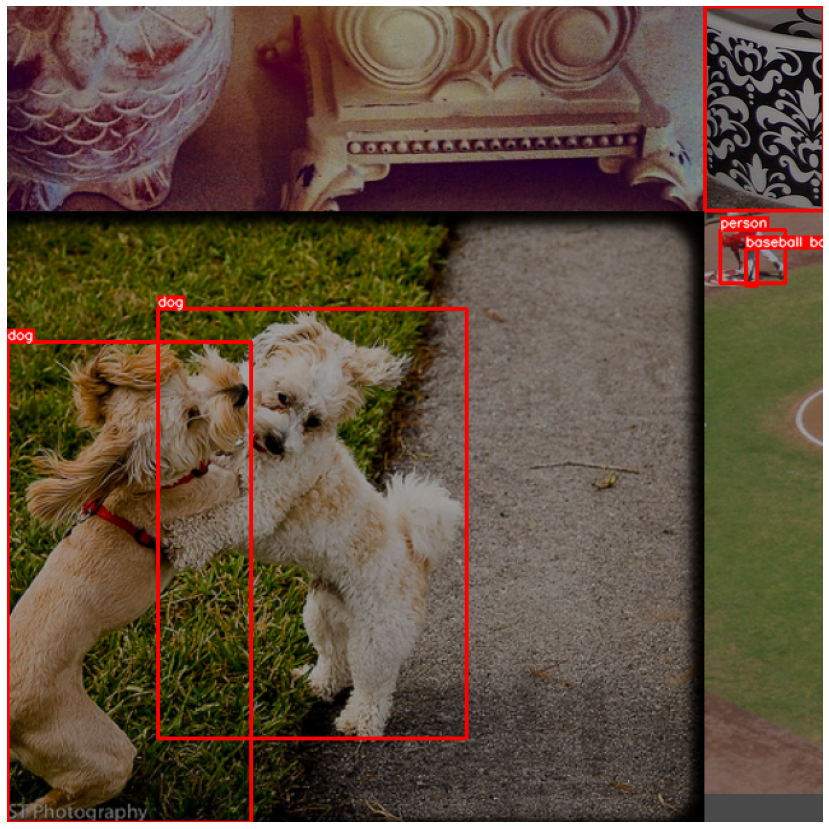

In [6]:
batch_data = pipeline.get_results(mode="train")
images = batch_data["image"].numpy()
bboxes = batch_data["bbox"].numpy()
visualize_image_with_box(images, bboxes)

## Define YOLOv5 Network

As mentioned earlier, YOLOv5 uses several special blocks to improve the detection accuracy, this section will illustrate its implementation in tensorflow.

In [7]:
def conv_block(x, c, k=1, s=1):
    x = layers.Conv2D(filters=c,
                      kernel_size=k,
                      strides=s,
                      padding='same',
                      use_bias=False,
                      kernel_regularizer=tf.keras.regularizers.L2(0.0005))(x)
    x = layers.BatchNormalization(momentum=0.97)(x)
    x = tf.nn.silu(x)
    return x


def bottleneck(x, c, k=1, shortcut=True):
    out = conv_block(x, c=c, k=1)
    out = conv_block(out, c=c, k=3)
    if shortcut and c == x.shape[-1]:
        out = out + x
    return out


def csp_bottleneck_conv3(x, c, n=1, shortcut=True):
    out1 = conv_block(x, c=c // 2)
    for _ in range(n):
        out1 = bottleneck(out1, c=c // 2, shortcut=shortcut)
    out2 = conv_block(x, c=c // 2)
    out = tf.concat([out1, out2], axis=-1)
    out = conv_block(out, c=c)
    return out


def spatial_pyramid_pooling(x, c, k=(5, 9, 13)):
    input_c = x.shape[-1]
    x = conv_block(x, c=input_c // 2)
    x = tf.concat([x] + [layers.MaxPool2D(pool_size=p, strides=1, padding='same')(x) for p in k], axis=-1)
    x = conv_block(x, c=c)
    return x


def yolov5(input_shape, num_classes, strides=(8, 16, 32)):
    inp = layers.Input(shape=input_shape)
    x = tf.concat([inp[:, ::2, ::2, :], inp[:, 1::2, ::2, :], inp[:, ::2, 1::2, :], inp[:, 1::2, 1::2, :]], axis=-1)
    x = conv_block(x, c=32, k=3)
    x = conv_block(x, c=64, k=3, s=2)
    x = csp_bottleneck_conv3(x, c=64)
    x = conv_block(x, c=128, k=3, s=2)
    x_4 = csp_bottleneck_conv3(x, c=128, n=3)
    x = conv_block(x_4, c=256, k=3, s=2)
    x_6 = csp_bottleneck_conv3(x, c=256, n=3)
    x = conv_block(x_6, c=512, k=3, s=2)
    x = spatial_pyramid_pooling(x, c=512)
    x = csp_bottleneck_conv3(x, 512, shortcut=False)
    x_10 = conv_block(x, 256)
    x = layers.UpSampling2D()(x_10)
    x = tf.concat([x, x_6], axis=-1)
    x = csp_bottleneck_conv3(x, 256, shortcut=False)
    x_14 = conv_block(x, 128)
    x = layers.UpSampling2D()(x_14)
    x = tf.concat([x, x_4], axis=-1)
    x_17 = csp_bottleneck_conv3(x, 128, shortcut=False)
    x = conv_block(x_17, 128, 3, 2)
    x = tf.concat([x, x_14], axis=-1)
    x_20 = csp_bottleneck_conv3(x, 256, shortcut=False)
    x = conv_block(x_20, 256, 3, 2)
    x = tf.concat([x, x_10], axis=-1)
    x_23 = csp_bottleneck_conv3(x, 512, shortcut=False)
    # initialize the bias for the final layer
    biases = []
    for stride, in_channel in zip(strides, (128, 256, 512)):
        bias = np.random.uniform(low=-(1 / in_channel)**0.5, high=(1 / in_channel)**0.5, size=(3, num_classes + 5))
        bias[:, 4] += math.log(8 / (640 / stride)**2)  # obj (8 objects per 640 image)
        bias[:, 5:] += math.log(0.6 / (num_classes - 0.99))  # cls
        biases.append(bias.flatten())
    out_17 = layers.Conv2D((num_classes + 5) * 3,
                           1,
                           bias_initializer=Constant(biases[0]),
                           kernel_regularizer=tf.keras.regularizers.L2(0.0005),
                           bias_regularizer=tf.keras.regularizers.L2(0.0005))(x_17)
    out_17 = layers.Reshape((out_17.shape[1], out_17.shape[2], 3, num_classes + 5))(out_17)
    out_20 = layers.Conv2D((num_classes + 5) * 3,
                           1,
                           bias_initializer=Constant(biases[1]),
                           kernel_regularizer=tf.keras.regularizers.L2(0.0005),
                           bias_regularizer=tf.keras.regularizers.L2(0.0005))(x_20)
    out_20 = layers.Reshape((out_20.shape[1], out_20.shape[2], 3, num_classes + 5))(out_20)
    out_23 = layers.Conv2D((num_classes + 5) * 3,
                           1,
                           bias_initializer=Constant(biases[2]),
                           kernel_regularizer=tf.keras.regularizers.L2(0.0005),
                           bias_regularizer=tf.keras.regularizers.L2(0.0005))(x_23)
    out_23 = layers.Reshape((out_23.shape[1], out_23.shape[2], 3, num_classes + 5))(out_23)  # B, h/32, w/32, 3, 85
    return tf.keras.Model(inputs=inp, outputs=[out_17, out_20, out_23])

In [8]:
init_lr = 1e-2 / 64 * batch_size
model = fe.build(lambda: yolov5(input_shape=(640, 640, 3), num_classes=80),
                 optimizer_fn=lambda: tf.optimizers.SGD(momentum=0.937, learning_rate=init_lr, nesterov=True))

## Training and Evaluation Network Operations

Image pixel values will be rescaled to [0, 1], then used as input to the network.  The network output will go through an extra step of decoding to translate the prediction into actual bounding box coordinates. Finally, the coordinates and classes will be used to compute the loss and update the model.  During evaluation, per-class Non-maximal suppression will be performed to filter out similar boxes. 

In [9]:
class ComputeLoss(LossOp):
    def __init__(self, inputs, outputs, img_size=640, mode=None):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)
        self.loss_conf = tf.losses.BinaryCrossentropy(reduction="none")
        self.loss_cls = tf.losses.BinaryCrossentropy(reduction="none")
        self.img_size = img_size

    def forward(self, data, state):
        pred, true = data
        true_box, true_obj, true_class = tf.split(true, (4, 1, -1), axis=-1)
        pred_box, pred_obj, pred_class = tf.split(pred, (4, 1, -1), axis=-1)
        num_classes = pred_class.shape[-1]
        true_class = tf.squeeze(tf.one_hot(tf.cast(true_class, tf.int32), depth=num_classes, axis=-1), -2)
        box_scale = 2 - 1.0 * true_box[..., 2] * true_box[..., 3] / (self.img_size**2)
        obj_mask = tf.squeeze(true_obj, -1)
        conf_focal = tf.squeeze(tf.math.pow(true_obj - pred_obj, 2), -1)
        iou = self.bbox_iou(pred_box, true_box, giou=True)
        iou_loss = (1 - iou) * obj_mask * box_scale
        conf_loss = conf_focal * self.loss_conf(true_obj, pred_obj)
        class_loss = obj_mask * self.loss_cls(true_class, pred_class)
        iou_loss = tf.reduce_mean(tf.reduce_sum(iou_loss, axis=[1, 2, 3]))
        conf_loss = tf.reduce_mean(tf.reduce_sum(conf_loss, axis=[1, 2, 3]))
        class_loss = tf.reduce_mean(tf.reduce_sum(class_loss, axis=[1, 2, 3])) * num_classes
        return iou_loss, conf_loss, class_loss

    @staticmethod
    def bbox_iou(bbox1, bbox2, giou=False, diou=False, ciou=False, epsilon=1e-7):
        b1x1, b1x2, b1y1, b1y2 = bbox1[..., 0], bbox1[..., 0] + bbox1[..., 2], bbox1[..., 1], bbox1[..., 1] + bbox1[..., 3]
        b2x1, b2x2, b2y1, b2y2  = bbox2[..., 0], bbox2[..., 0] + bbox2[..., 2], bbox2[..., 1], bbox2[..., 1] + bbox2[..., 3]
        # intersection area
        inter = tf.maximum(tf.minimum(b1x2, b2x2) - tf.maximum(b1x1, b2x1), 0) * tf.maximum(
            tf.minimum(b1y2, b2y2) - tf.maximum(b1y1, b2y1), 0)
        # union area
        w1, h1 = b1x2 - b1x1 + epsilon, b1y2 - b1y1 + epsilon
        w2, h2 = b2x2 - b2x1 + epsilon, b2y2 - b2y1 + epsilon
        union = w1 * h1 + w2 * h2 - inter + epsilon
        # iou
        iou = inter / union
        if giou or diou or ciou:
            # enclosing box
            cw = tf.maximum(b1x2, b2x2) - tf.minimum(b1x1, b2x1)
            ch = tf.maximum(b1y2, b2y2) - tf.minimum(b1y1, b2y1)
            if giou:
                enclose_area = cw * ch + epsilon
                return iou - (enclose_area - union) / enclose_area
            if diou or ciou:
                c2 = cw**2 + ch**2 + epsilon
                rho2 = ((b2x1 + b2x2) - (b1x1 + b1x2))**2 / 4 + ((b2y1 + b2y2) - (b1y1 + b1y2))**2 / 4
                if diou:
                    return iou - rho2 / c2
                elif ciou:
                    v = (4 / math.pi**2) * tf.pow(tf.atan(w2 / h2) - tf.atan(w1 / h1), 2)
                    alpha = v / (1 - iou + v)
                    return iou - (rho2 / c2 + v * alpha)
        return tf.clip_by_value(iou, 0, 1)


class Rescale(TensorOp):
    def forward(self, data, state):
        return data / 255


class DecodePred(TensorOp):
    def __init__(self, inputs, outputs, mode=None):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)
        self.strides = [8, 16, 32]
        self.num_anchor = 3
        self.width, self.height = 640, 640
        self.grids = self.create_grid(self.strides, self.num_anchor)
        anchor_s = [(10, 13), (16, 30), (33, 23)]
        anchor_m = [(30, 61), (62, 45), (59, 119)]
        anchor_l = [(116, 90), (156, 198), (373, 326)]
        self.anchors = self.create_anchor(anchor_s, anchor_m, anchor_l, self.strides)

    def create_grid(self, strides, num_anchor):
        grids = []
        for stride in strides:
            x_coor = [stride * i for i in range(self.width // stride)]
            y_coor = [stride * i for i in range(self.height // stride)]
            xx, yy = np.meshgrid(x_coor, y_coor)
            xx, yy = np.float32(xx), np.float32(yy)
            xx, yy = np.stack([xx] * num_anchor, axis=-1), np.stack([yy] * num_anchor, axis=-1)
            grids.append(tf.convert_to_tensor(np.stack([xx, yy], axis=-1)))
        return grids

    def create_anchor(self, anchor_s, anchor_m, anchor_l, strides):
        anchors = []
        for anchor, stride in zip([anchor_s, anchor_m, anchor_l], strides):
            feature_size_x, feature_size_y = self.width // stride, self.height // stride
            anchor = np.array(anchor, dtype="float32").reshape((1, 1, 3, 2))
            anchor = np.tile(anchor, [feature_size_y, feature_size_x, 1, 1])
            anchors.append(tf.convert_to_tensor(anchor))
        return anchors

    def forward(self, data, state):
        conv_sbbox = self.decode(data[0], self.grids[0], self.anchors[0], self.strides[0])
        conv_mbbox = self.decode(data[1], self.grids[1], self.anchors[1], self.strides[1])
        conv_lbbox = self.decode(data[2], self.grids[2], self.anchors[2], self.strides[2])
        return conv_sbbox, conv_mbbox, conv_lbbox

    def decode(self, conv_bbox, grid, anchor, stride):
        batch_size = conv_bbox.shape[0]
        grid, anchor = tf.expand_dims(grid, 0), tf.expand_dims(anchor, 0)
        grid, anchor = tf.tile(grid, [batch_size, 1, 1, 1, 1]), tf.tile(anchor, [batch_size, 1, 1, 1, 1])
        conv_bbox = tf.sigmoid(conv_bbox)
        bbox_pred, conf_pred, cls_pred = conv_bbox[..., 0:4], conv_bbox[..., 4:5], conv_bbox[..., 5:]
        xcyc_pred, wh_pred = bbox_pred[..., 0:2], bbox_pred[..., 2:4]
        xcyc_pred = (xcyc_pred * 2 - 0.5) * stride + grid
        wh_pred = (wh_pred * 2)**2 * anchor
        x1y1_pred = xcyc_pred - wh_pred / 2
        result = tf.concat([x1y1_pred, wh_pred, conf_pred, cls_pred], axis=-1)
        return result


class PredictBox(TensorOp):
    def __init__(self, inputs, outputs, mode, width, height, max_outputs=500, conf_threshold=0.4):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)
        self.width = width
        self.height = height
        self.max_outputs = max_outputs
        self.conf_threshold = conf_threshold

    def forward(self, data, state):
        conv_sbbox, conv_mbbox, conv_lbbox = data
        batch_size = conv_sbbox.shape[0]
        final_results = []
        for idx in range(batch_size):
            pred_s, pred_m, pred_l = conv_sbbox[idx], conv_mbbox[idx], conv_lbbox[idx]
            pred_s, pred_m, pred_l = tf.reshape(pred_s, (-1, 85)), tf.reshape(pred_m, (-1, 85)), tf.reshape(pred_l, (-1, 85))
            preds = tf.concat([pred_s, pred_m, pred_l], axis=0)
            preds = preds[preds[:, 4] > self.conf_threshold]  # filter by confidence
            classes = tf.argmax(preds[:, 5:], axis=-1)
            unique_classes = tf.unique(classes)[0]
            selected_boxes_all_classes = tf.zeros(shape=[0, 6], dtype=tf.float32)
            for clss in unique_classes:
                tf.autograph.experimental.set_loop_options(shape_invariants=[(selected_boxes_all_classes,
                                                                              tf.TensorShape([None, 6]))])
                mask = tf.math.equal(classes, clss)
                preds_cls = tf.boolean_mask(preds, mask)
                x1, y1, w, h = preds_cls[:, 0], preds_cls[:, 1], preds_cls[:, 2], preds_cls[:, 3]
                x2, y2 = x1 + w, y1 + h
                conf_score, label = preds_cls[:, 4], tf.boolean_mask(classes, mask)
                selected_bboxes = tf.stack([y1, x1, y2, x2, conf_score, tf.cast(label, tf.float32)], axis=-1)
                # nms for every class
                nms_keep = tf.image.non_max_suppression(selected_bboxes[:, :4],
                                                        selected_bboxes[:, 4],
                                                        max_output_size=50,
                                                        iou_threshold=0.35)
                selected_bboxes = tf.gather(selected_bboxes, nms_keep)
                selected_boxes_all_classes = tf.concat([selected_boxes_all_classes, selected_bboxes], axis=0)
            # clip bounding boxes to image size
            y1_abs = tf.clip_by_value(selected_boxes_all_classes[:, 0], 0, self.height)
            x1_abs = tf.clip_by_value(selected_boxes_all_classes[:, 1], 0, self.width)
            height_abs = tf.clip_by_value(selected_boxes_all_classes[:, 2] - y1_abs, 0, self.height - y1_abs)
            width_abs = tf.clip_by_value(selected_boxes_all_classes[:, 3] - x1_abs, 0, self.width - x1_abs)
            labels_score, labels = selected_boxes_all_classes[:, 4], selected_boxes_all_classes[:, 5]
            # final output: [x1, y1, w, h, label, label_score, select_or_not]
            results_single = [x1_abs, y1_abs, width_abs, height_abs, labels, labels_score, tf.ones_like(x1_abs)]
            results_single = tf.stack(results_single, axis=-1)
            # pad 0 to other rows to improve performance
            results_single = tf.pad(results_single, [(0, self.max_outputs - tf.shape(results_single)[0]), (0, 0)])
            final_results.append(results_single)
        final_results = tf.stack(final_results)
        return final_results

In [10]:
network = fe.Network(ops=[
    Rescale(inputs="image", outputs="image"),
    ModelOp(model=model, inputs="image", outputs=("pred_s", "pred_m", "pred_l")),
    DecodePred(inputs=("pred_s", "pred_m", "pred_l"), outputs=("pred_s", "pred_m", "pred_l")),
    ComputeLoss(inputs=("pred_s", "gt_sbbox"), outputs=("sbbox_loss", "sconf_loss", "scls_loss")),
    ComputeLoss(inputs=("pred_m", "gt_mbbox"), outputs=("mbbox_loss", "mconf_loss", "mcls_loss")),
    ComputeLoss(inputs=("pred_l", "gt_lbbox"), outputs=("lbbox_loss", "lconf_loss", "lcls_loss")),
    Average(inputs=("sbbox_loss", "mbbox_loss", "lbbox_loss"), outputs="bbox_loss"),
    Average(inputs=("sconf_loss", "mconf_loss", "lconf_loss"), outputs="conf_loss"),
    Average(inputs=("scls_loss", "mcls_loss", "lcls_loss"), outputs="cls_loss"),
    Average(inputs=("bbox_loss", "conf_loss", "cls_loss"), outputs="total_loss"),
    PredictBox(width=640, height=640, inputs=("pred_s", "pred_m", "pred_l"), outputs="box_pred", mode="eval"),
    UpdateOp(model=model, loss_name="total_loss")
])

## Metrics and Learning Rate Scheduling

We will use mean Average Precision (mAP) as object detection metric. The learning rate schedule is a combination of two schedulers:
1. During the first 3 epochs, learning rate will start from 0 and increase linearly per step until it reaches initial learning rate (0.01 when batch size is 64)
2. For the rest of epochs, apply cosine-decay to the learning rate every epoch until it reaches 1% of initial learning rate in the end.

In [11]:
def lr_schedule_warmup(step, train_steps_epoch, init_lr):
    warmup_steps = train_steps_epoch * 3
    if step < warmup_steps:
        lr = init_lr / warmup_steps * step
    else:
        lr = init_lr
    return lr

traces = [
    MeanAveragePrecision(num_classes=80, true_key='bbox', pred_key='box_pred', mode="eval"),
    BestModelSaver(model=model, save_dir=model_dir, metric='mAP', save_best_mode="max")
]
lr_schedule = {
    1:
    LRScheduler(
        model=model,
        lr_fn=lambda step: lr_schedule_warmup(
            step, train_steps_epoch=np.ceil(len(train_ds) / batch_size), init_lr=init_lr)),
    4:
    LRScheduler(
        model=model,
        lr_fn=lambda epoch: cosine_decay(
            epoch, cycle_length=epochs - 3, init_lr=init_lr, min_lr=init_lr / 100, start=4))
}
traces.append(EpochScheduler(lr_schedule))

## Train the YOLOv5

We will train the model for 200 epochs, **the training takes ~2 days on 4 Nvidia V100 GPU**

In [ ]:
estimator = fe.Estimator(pipeline=pipeline,
                         network=network,
                         epochs=epochs,
                         traces=traces,
                         monitor_names=["bbox_loss", "conf_loss", "cls_loss"],
                         train_steps_per_epoch=train_steps_per_epoch,
                         eval_steps_per_epoch=eval_steps_per_epoch)
estimator.fit()

## Run Inferencing

After training the model, we are ready to run the inferencing. For illustration purpose, we use evaluation data.

In [13]:
eval_data = pipeline.get_results(mode="eval")
images_eval = eval_data["image"].numpy()
eval_data = network.transform(eval_data, mode="eval")
bboxes_eval = eval_data["box_pred"][..., :5]

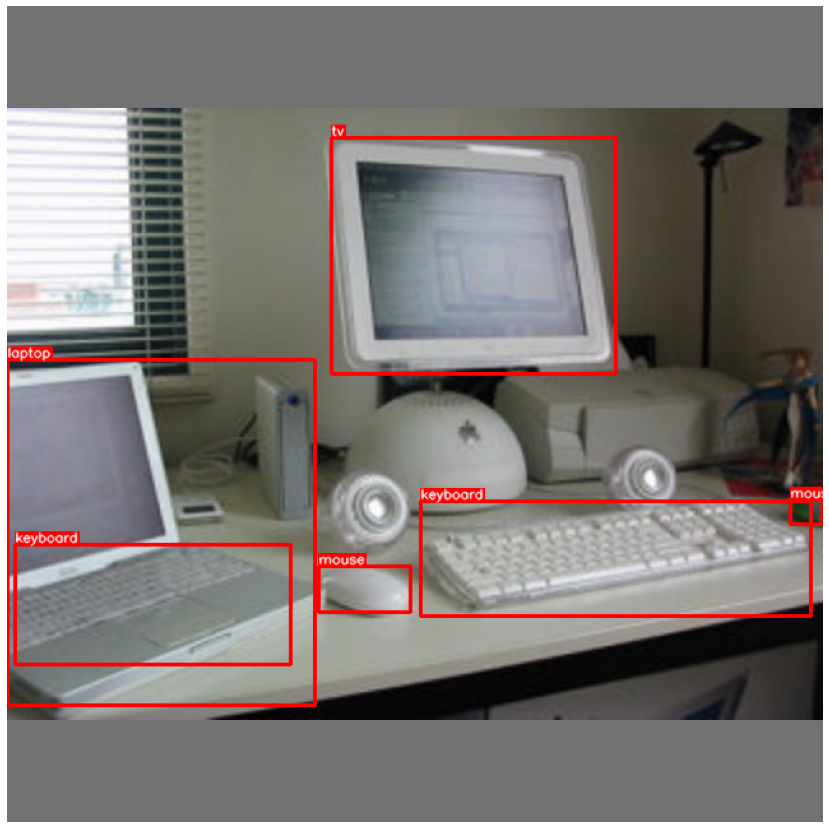

In [21]:
visualize_image_with_box(images_eval, bboxes_eval)

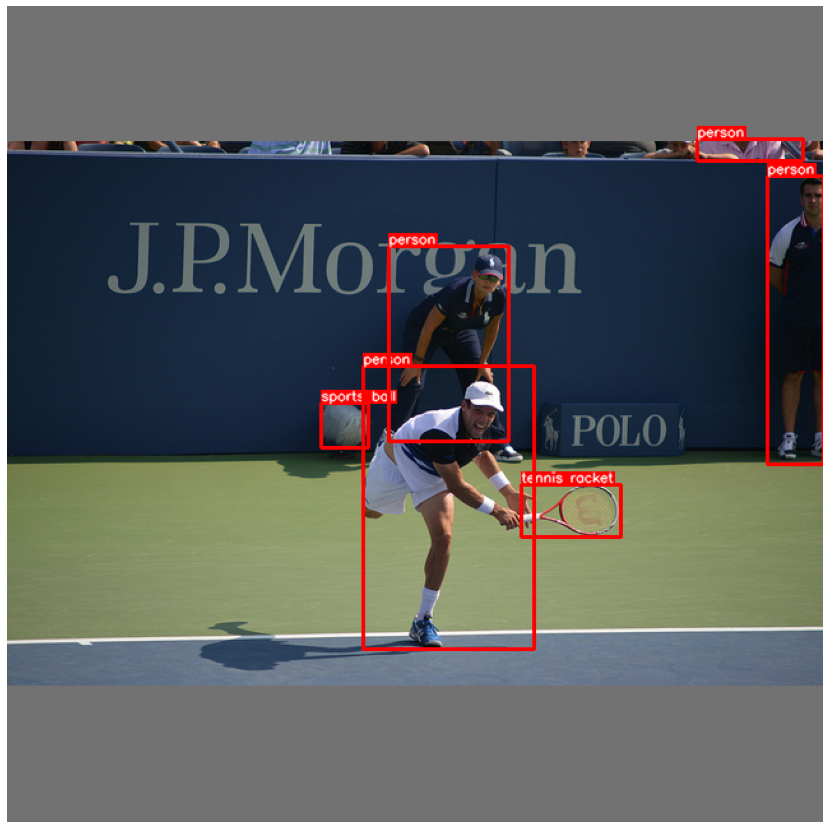

In [24]:
visualize_image_with_box(images_eval, bboxes_eval)